In [1]:
1+2

3

In [2]:
!nvidia-smi

Sat Nov 22 02:14:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Create a dual-demo Colab/VSCode notebook:
# A) Dynamic PINN fitting visualization
# B) Minimal LLM with RAG + agent-like retrieval, simple Gradio UI


# Dual Demo: PINN Live Visualization + Minimal LLM (RAG/Agent)

**Run order:** 0 → A → B.  Works in VS Code ↔ Colab.

In [1]:

# 0. Setup & system check

import json, platform, subprocess, torch, os, sys
def sh(cmd):
    try: return subprocess.check_output(cmd, shell=True, text=True).strip()
    except: return "n/a"
info = {
  "python": platform.python_version(),
  "torch": torch.__version__,
  "cuda_runtime": torch.version.cuda,
  "cuda_available": torch.cuda.is_available(),
  "gpu_name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU",
  "nvidia_smi": sh("nvidia-smi --query-gpu=name,memory.total,memory.used,utilization.gpu --format=csv,noheader,nounits") if torch.cuda.is_available() else "n/a"
}
print(json.dumps(info, indent=2, ensure_ascii=False))

# 0.1 install deps (idempotent)
# Install (first run only)"))
#!%pip -q install transformers accelerate bitsandbytes sentencepiece gradio faiss-cpu sentence-transformers -U


In [2]:
!%pip -q install transformers accelerate bitsandbytes sentencepiece gradio faiss-cpu sentence-transformers -U


/bin/bash: line 1: fg: no job control


In [5]:
# A. PINN live
def run_pinn2d_poisson(
    epochs=2000,
    n_int=65536,           # ↑ 这两个加大可明显提高 GPU 占用
    n_bc_per_edge=4096,
    width=128, depth=5,
    lr=2e-3,
    refresh=20,
    use_amp=True           # GPU 上建议 True
):
    import torch, math, numpy as np, matplotlib.pyplot as plt
    from IPython.display import clear_output, display
    import os

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(1234)

    class Net(torch.nn.Module):
        def __init__(self, in_dim=2, out_dim=1, width=128, depth=5):
            super().__init__()
            layers = [torch.nn.Linear(in_dim, width), torch.nn.Tanh()]
            for _ in range(depth - 1):
                layers += [torch.nn.Linear(width, width), torch.nn.Tanh()]
            layers += [torch.nn.Linear(width, out_dim)]
            self.m = torch.nn.Sequential(*layers)
        def forward(self, x): return self.m(x)

    def u_true(xy):
        x, y = xy[:,0:1], xy[:,1:2]
        return torch.sin(math.pi*x)*torch.sin(math.pi*y)

    def f_rhs(xy):
        x, y = xy[:,0:1], xy[:,1:2]
        return 2*(math.pi**2)*torch.sin(math.pi*x)*torch.sin(math.pi*y)

    def laplace_u(model, xy):
        xy = xy.requires_grad_(True)
        u  = model(xy)
        grads = torch.autograd.grad(u, xy, torch.ones_like(u), create_graph=True)[0]
        ux, uy = grads[:,0:1], grads[:,1:2]
        uxx = torch.autograd.grad(ux, xy, torch.ones_like(ux), create_graph=True)[0][:,0:1]
        uyy = torch.autograd.grad(uy, xy, torch.ones_like(uy), create_graph=True)[0][:,1:2]
        return u, uxx + uyy

    # sample interior
    xy_int = torch.rand(n_int, 2, device=device)

    # sample boundary (4 edges)
    def edge_xy(n, which):
        t = torch.rand(n,1,device=device)
        if   which=="x0": return torch.cat([torch.zeros_like(t), t], dim=1)
        elif which=="x1": return torch.cat([torch.ones_like(t),  t], dim=1)
        elif which=="y0": return torch.cat([t, torch.zeros_like(t)], dim=1)
        else:             return torch.cat([t, torch.ones_like(t)],  dim=1)

    nbc = n_bc_per_edge
    xy_bc = torch.cat([edge_xy(nbc,"x0"), edge_xy(nbc,"x1"),
                       edge_xy(nbc,"y0"), edge_xy(nbc,"y1")], dim=0)
    u_bc  = torch.zeros(xy_bc.size(0),1,device=device)

    model = Net(width=width, depth=depth).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    sch   = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.997)

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type=="cuda"))

    fig = plt.figure(figsize=(12,3.6))

    for ep in range(1, epochs+1):
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(use_amp and device.type=="cuda")):
            u_pred, lap_u = laplace_u(model, xy_int)
            res  = -lap_u - f_rhs(xy_int)         # -Δu - f = 0
            loss_pde = (res**2).mean()

            u_b = model(xy_bc)
            loss_bc = ((u_b - u_bc)**2).mean()

            loss = loss_pde + loss_bc

        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        if ep%50==0: sch.step()

        if ep % refresh == 0 or ep==1:
            clear_output(wait=True)
            fig.clf()
            # 可视化网格
            with torch.no_grad():
                g = 128  # 显示分辨率
                xs = torch.linspace(0,1,g,device=device)
                ys = torch.linspace(0,1,g,device=device)
                X, Y = torch.meshgrid(xs, ys, indexing="xy")
                XY = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
                U_pred = model(XY).reshape(g,g)
                U_true = u_true(XY).reshape(g,g)
                _, lap = laplace_u(model, XY)
                R = (-lap - f_rhs(XY)).reshape(g,g)

            # 预测
            ax1 = fig.add_subplot(1,3,1)
            im1 = ax1.imshow(U_pred.detach().cpu().numpy(), origin="lower", extent=[0,1,0,1])
            ax1.set_title("PINN prediction"); fig.colorbar(im1, ax=ax1, fraction=0.046)
            # 真值
            ax2 = fig.add_subplot(1,3,2)
            im2 = ax2.imshow(U_true.detach().cpu().numpy(), origin="lower", extent=[0,1,0,1])
            ax2.set_title("Analytic solution"); fig.colorbar(im2, ax=ax2, fraction=0.046)
            # 残差
            ax3 = fig.add_subplot(1,3,3)
            im3 = ax3.imshow(R.abs().detach().cpu().numpy(), origin="lower", extent=[0,1,0,1])
            ax3.set_title("|PDE residual|"); fig.colorbar(im3, ax=ax3, fraction=0.046)

            fig.suptitle(f"Epoch {ep} | loss={loss.item():.3e} (pde {loss_pde.item():.3e}, bc {loss_bc.item():.3e})")
            display(fig); plt.pause(0.001)
            os.makedirs("runs", exist_ok=True)

            # stop if loss becomes NaN/Inf and save a crash checkpoint for debugging
            if not torch.isfinite(loss).all():
                print(f"Early stop: non-finite loss at epoch {ep}: {loss.item()}")
                torch.save(model.state_dict(), "runs/pinn_crash.pth")
                break

            # periodic checkpointing to avoid losing progress
            if ep % 200 == 0 or ep == epochs:
                ckpt_path = f"runs/pinn_ep{ep}.pth"
                torch.save(model.state_dict(), ckpt_path)
                print(f"Saved checkpoint: {ckpt_path}")

            # occasional lightweight status print
            if ep % (refresh * 5) == 0:
                total_params = sum(p.numel() for p in model.parameters())
                param_norm = sum(p.detach().norm().item()**2 for p in model.parameters()) ** 0.5
                print(f"Epoch {ep}: loss={loss.item():.3e}, params={total_params}, param_norm={param_norm:.3e}")
    fig.savefig("runs/pinn2d_live.pdf"); fig.savefig("runs/pinn2d_live.svg"); plt.close(fig)
    print("Saved: runs/pinn2d_live.pdf/svg")
    return model


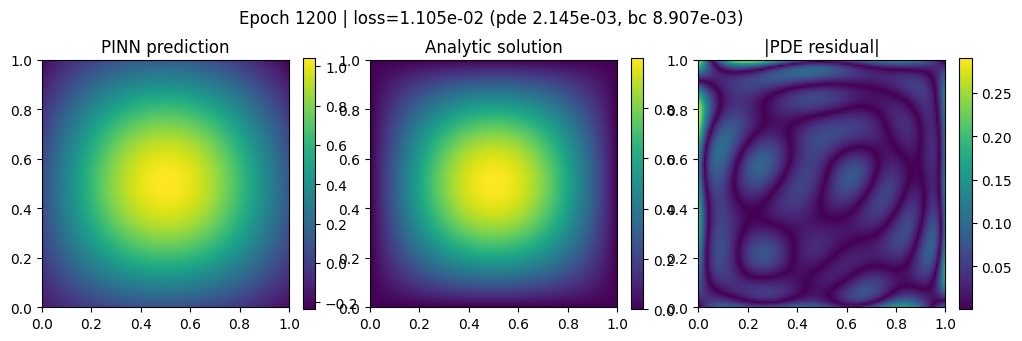

Saved checkpoint: runs/pinn_ep1200.pth
Epoch 1200: loss=1.105e-02, params=66561, param_norm=1.608e+01
Saved: runs/pinn2d_live.pdf/svg


In [ ]:
from IPython.display import clear_output, display
import os

# redefine a patched version of the PINN function that avoids calling autograd inside torch.no_grad()
def run_pinn2d_poisson(
    epochs=2000,
    n_int=65536,
    n_bc_per_edge=4096,
    width=128, depth=5,
    lr=2e-3,
    refresh=20,
    use_amp=True
):
    import torch, math, numpy as np, matplotlib.pyplot as plt

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(1234)

    class Net(torch.nn.Module):
        def __init__(self, in_dim=2, out_dim=1, width=128, depth=5):
            super().__init__()
            layers = [torch.nn.Linear(in_dim, width), torch.nn.Tanh()]
            for _ in range(depth - 1):
                layers += [torch.nn.Linear(width, width), torch.nn.Tanh()]
            layers += [torch.nn.Linear(width, out_dim)]
            self.m = torch.nn.Sequential(*layers)
        def forward(self, x): return self.m(x)

    def u_true(xy):
        x, y = xy[:,0:1], xy[:,1:2]
        return torch.sin(math.pi*x)*torch.sin(math.pi*y)

    def f_rhs(xy):
        x, y = xy[:,0:1], xy[:,1:2]
        return 2*(math.pi**2)*torch.sin(math.pi*x)*torch.sin(math.pi*y)

    def laplace_u(model, xy):
        xy = xy.requires_grad_(True)
        u  = model(xy)
        grads = torch.autograd.grad(u, xy, torch.ones_like(u), create_graph=True)[0]
        ux, uy = grads[:,0:1], grads[:,1:2]
        uxx = torch.autograd.grad(ux, xy, torch.ones_like(ux), create_graph=True)[0][:,0:1]
        uyy = torch.autograd.grad(uy, xy, torch.ones_like(uy), create_graph=True)[0][:,1:2]
        return u, uxx + uyy

    # sample interior
    xy_int = torch.rand(n_int, 2, device=device)

    # sample boundary (4 edges)
    def edge_xy(n, which):
        t = torch.rand(n,1,device=device)
        if   which=="x0": return torch.cat([torch.zeros_like(t), t], dim=1)
        elif which=="x1": return torch.cat([torch.ones_like(t),  t], dim=1)
        elif which=="y0": return torch.cat([t, torch.zeros_like(t)], dim=1)
        else:             return torch.cat([t, torch.ones_like(t)],  dim=1)

    nbc = n_bc_per_edge
    xy_bc = torch.cat([edge_xy(nbc,"x0"), edge_xy(nbc,"x1"),
                       edge_xy(nbc,"y0"), edge_xy(nbc,"y1")], dim=0)
    u_bc  = torch.zeros(xy_bc.size(0),1,device=device)

    model = Net(width=width, depth=depth).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    sch   = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.997)

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type=="cuda"))

    fig = plt.figure(figsize=(12,3.6))

    for ep in range(1, epochs+1):
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(use_amp and device.type=="cuda")):
            u_pred, lap_u = laplace_u(model, xy_int)
            res  = -lap_u - f_rhs(xy_int)         # -Δu - f = 0
            loss_pde = (res**2).mean()

            u_b = model(xy_bc)
            loss_bc = ((u_b - u_bc)**2).mean()

            loss = loss_pde + loss_bc

        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        if ep%50==0: sch.step()

        if ep % refresh == 0 or ep==1:
            clear_output(wait=True)
            fig.clf()
            # visualization grid
            with torch.no_grad():
                g = 128  # display resolution
                xs = torch.linspace(0,1,g,device=device)
                ys = torch.linspace(0,1,g,device=device)
                X, Y = torch.meshgrid(xs, ys, indexing="xy")
                XY = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1).to(device)

                # predictions and analytic solution without grads (save memory)
                U_pred = model(XY).reshape(g,g).detach().cpu()
                U_true = u_true(XY).reshape(g,g).detach().cpu()

            # compute Laplacian / residual with autograd enabled (separately)
            with torch.enable_grad():
                XY_grad = XY.clone().detach().requires_grad_(True)
                _, lap = laplace_u(model, XY_grad)
                R = (-lap - f_rhs(XY_grad)).reshape(g,g).detach().cpu()

            # plotting
            ax1 = fig.add_subplot(1,3,1)
            im1 = ax1.imshow(U_pred.numpy(), origin="lower", extent=[0,1,0,1])
            ax1.set_title("PINN prediction"); fig.colorbar(im1, ax=ax1, fraction=0.046)
            ax2 = fig.add_subplot(1,3,2)
            im2 = ax2.imshow(U_true.numpy(), origin="lower", extent=[0,1,0,1])
            ax2.set_title("Analytic solution"); fig.colorbar(im2, ax=ax2, fraction=0.046)
            ax3 = fig.add_subplot(1,3,3)
            im3 = ax3.imshow(R.abs().numpy(), origin="lower", extent=[0,1,0,1])
            ax3.set_title("|PDE residual|"); fig.colorbar(im3, ax=ax3, fraction=0.046)

            fig.suptitle(f"Epoch {ep} | loss={loss.item():.3e} (pde {loss_pde.item():.3e}, bc {loss_bc.item():.3e})")
            display(fig); plt.pause(0.001)
            os.makedirs("runs", exist_ok=True)

            if not torch.isfinite(loss).all():
                print(f"Early stop: non-finite loss at epoch {ep}: {loss.item()}")
                torch.save(model.state_dict(), "runs/pinn_crash.pth")
                break

            if ep % 200 == 0 or ep == epochs:
                ckpt_path = f"runs/pinn_ep{ep}.pth"
                torch.save(model.state_dict(), ckpt_path)
                print(f"Saved checkpoint: {ckpt_path}")

            if ep % (refresh * 5) == 0:
                total_params = sum(p.numel() for p in model.parameters())
                param_norm = sum(p.detach().norm().item()**2 for p in model.parameters()) ** 0.5
                print(f"Epoch {ep}: loss={loss.item():.3e}, params={total_params}, param_norm={param_norm:.3e}")
    fig.savefig("runs/pinn2d_live.pdf"); fig.savefig("runs/pinn2d_live.svg"); plt.close(fig)
    print("Saved: runs/pinn2d_live.pdf/svg")
    return model

# alias and run
train_pinn_live = run_pinn2d_poisson
model = train_pinn_live(epochs=1200, refresh=10)


In [9]:

# B. Minimal LLM with RAG + agent-like loop  (no faiss dependency)

import os, re, math, json, torch, gradio as gr, importlib.util
from transformers import AutoTokenizer, AutoModelForCausalLM
try:
    from transformers import BitsAndBytesConfig
    HAS_BNB = importlib.util.find_spec("bitsandbytes") is not None
except Exception:
    BitsAndBytesConfig = None
    HAS_BNB = False
from sentence_transformers import SentenceTransformer
import numpy as np

def pick_model():
    if torch.cuda.is_available():
        return "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # small & fast
    else:
        return "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

model_id = pick_model()
device = "cuda" if torch.cuda.is_available() else "cpu"
use_4bit = device == "cuda" and HAS_BNB and BitsAndBytesConfig is not None
if not HAS_BNB and device == "cuda":
    print("bitsandbytes not available; using float16 instead of 4-bit.")
elif device == "cpu":
    print("CUDA not available; running on CPU.")

quant = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
) if use_4bit else None

tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
if use_4bit:
    llm = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        quantization_config=quant,
    )
elif device == "cuda":
    llm = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        device_map="auto",
    )
else:
    llm = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float32,
        device_map="auto",
    )

embedder = SentenceTransformer(
    "sentence-transformers/all-MiniLM-L6-v2",
    device=device,
)

class VectorDB:
    def __init__(self, dim=384):
        self.dim = dim
        self.texts = []
        self.ids = []
        self.vecs = None  # shape: [N, dim], float32, L2-normalized

    def add_texts(self, chunks, ids=None):
        if not chunks:
            return
        vecs = embedder.encode(
            chunks,
            normalize_embeddings=True,
            convert_to_numpy=True,
            batch_size=64,
        ).astype("float32")

        if self.vecs is None:
            self.vecs = vecs
        else:
            self.vecs = np.vstack([self.vecs, vecs])

        base = len(self.ids)
        if ids is None:
            ids = [f"d{base + i}" for i in range(len(chunks))]
        self.texts.extend(chunks)
        self.ids.extend(ids)

    def search(self, q, k=4):
        if self.vecs is None or len(self.texts) == 0:
            return []
        v = embedder.encode(
            [q],
            normalize_embeddings=True,
            convert_to_numpy=True,
        )[0].astype("float32")  # [dim]
        sims = self.vecs @ v  # cosine similarity (inner product of normalized vecs)
        k = min(k, len(self.texts))
        topk_idx = np.argsort(-sims)[:k]
        hits = [(float(sims[i]), self.texts[i]) for i in topk_idx]
        return hits

db = VectorDB(dim=384)

def chunk_text(text, chunk_size=500, overlap=80):
    text = re.sub(r"\s+", " ", text.strip())
    chunks = []
    i = 0
    while i < len(text):
        end = min(i + chunk_size, len(text))
        chunk = text[i:end]
        chunks.append(chunk)
        i += chunk_size - overlap
    return chunks

SYSTEM = "You are a helpful assistant. Answer with concise, well-structured English. Cite sources by [#] index when relevant."

def rag_answer(history, user, top_k=4, temperature=0.7, max_new_tokens=192):
    ctx_hits = db.search(user, k=top_k)
    context = "

".join([f"[{i+1}] {t}" for i, (_, t) in enumerate(ctx_hits)]) if ctx_hits else ""
    messages = [
        {
            "role": "system",
            "content": SYSTEM + ("

Context:
" + context if context else ""),
        },
        *[
            {"role": "user", "content": u} if i % 2 == 0 else {"role": "assistant", "content": u}
            for pair in history
            for i, u in enumerate(pair)
            if u is not None
        ],
        {"role": "user", "content": user},
    ]
    prompt = tok.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    inputs = tok(prompt, return_tensors="pt").to(llm.device)
    out = llm.generate(
        **inputs,
        do_sample=True,
        temperature=float(temperature),
        top_p=0.9,
        max_new_tokens=int(max_new_tokens),
        pad_token_id=tok.eos_token_id,
    )
    text = tok.decode(out[0], skip_special_tokens=True)
    if context:
        text += "

Sources: " + ", ".join([f"[{i+1}]" for i in range(len(ctx_hits))])
    return text

def add_docs(files, chunk_size, overlap):
    total = 0
    for f in files:
        try:
            if isinstance(f, bytes):  # gr.Files may give bytes in some backends
                txt = f.decode("utf-8", errors="ignore")
            else:
                txt = f.read().decode("utf-8", errors="ignore")
        except Exception:
            if isinstance(f, bytes):
                txt = f.decode("latin-1", errors="ignore")
            else:
                txt = f.read().decode("latin-1", errors="ignore")
        chunks = chunk_text(txt, chunk_size=int(chunk_size), overlap=int(overlap))
        db.add_texts(chunks)
        total += len(chunks)
    return f"Indexed {total} chunks. Total vectors: {len(db.texts)}"

with gr.Blocks() as app:
    gr.Markdown(f"### Minimal RAG/Agent UI · Model: **{model_id}**")

    with gr.Tab("Chat"):
        chat = gr.Chatbot(height=360)
        with gr.Row():
            msg = gr.Textbox(label="Your message", scale=4)
            send = gr.Button("Send", scale=1)
        with gr.Accordion("Generation Params", open=False):
            temp = gr.Slider(0.1, 1.5, value=0.7, step=0.05, label="temperature")
            mx = gr.Slider(64, 512, value=192, step=16, label="max_new_tokens")

        def on_send(history, user, temperature, max_new_tokens):
            if not user:
                return history, ""
            reply = rag_answer(
                history,
                user,
                top_k=4,
                temperature=temperature,
                max_new_tokens=max_new_tokens,
            )
            history = history + [[user, reply]]
            return history, ""

        send.click(on_send, [chat, msg, temp, mx], [chat, msg])
        msg.submit(on_send, [chat, msg, temp, mx], [chat, msg])

    with gr.Tab("Upload & Index"):
        up = gr.Files(file_types=["text"], file_count="multiple", label="Upload .txt files")
        chunk = gr.Slider(200, 1200, value=500, step=50, label="chunk_size")
        ovl = gr.Slider(0, 200, value=80, step=10, label="overlap")
        out = gr.Markdown("No index yet.")
        go = gr.Button("Build Index")
        go.click(add_docs, [up, chunk, ovl], [out])

# To launch, run:
# app.launch(share=True)


ModuleNotFoundError: No module named 'faiss'